In [1]:
import jax
from jax import numpy as jnp
from jax import jit, grad
from jax import random, vmap

In [2]:
def f(x1,x2,x3, fun_num):
    if(fun_num==0):
        return x1**5 + 2*(x2**3) + 4*(x3)
    return x1*5+x2

jitted_f = jit(f, static_argnums=(3,))

print(grad(f)(2.,3.,5., 0))


@jit
def f(x1, x2):
    return jnp.log(x1)+jnp.log(x2*x1)

print(grad(f)(1.0, 1.))

80.0
2.0


In [3]:
@jit
def nonamefunction(x):
    print(x.shape)
    return x


In [4]:
nonamefunction(jnp.zeros((2,2)))
nonamefunction(jnp.zeros((2,2)))
nonamefunction(jnp.zeros((1,1)))

(2, 2)
(1, 1)


DeviceArray([[0.]], dtype=float32)

In [5]:
key = random.PRNGKey(1)

def wandb(in_c, o_c, key):
    keys = random.split(key, 2)
    w = 0.01*random.normal(keys[0], (o_c, in_c))
    b = 0.01*random.normal(keys[1], (o_c,))
    return [w,b]

def mlp(sizes, key):
    keys = random.split(key, len(sizes))
    params = []
    for i in range(len(keys)-1):
        key_ = keys[i]
        in_c = sizes[i]
        o_c = sizes[i+1]
        params.append(wandb(in_c, o_c, key_))
    return params

@jit
def relu(x):
    return jnp.maximum(0.1*x, x)

@jit
def forward(params, x):
    for w,b in params[:-1]:
        x = relu(jnp.dot(w, x)+b)
    y_pred = jnp.dot(params[-1][0], x) + params[-1][1]
    return y_pred

In [6]:
sizes = [1, 128, 256, 1]

mlp_params = mlp(sizes, key)
forward(mlp_params, jnp.zeros(1))

DeviceArray([-0.00080903], dtype=float32)

In [7]:
batch_forward = jit(vmap(forward, in_axes=(None, 0)))

In [8]:
batch_forward(mlp_params, jnp.zeros((10, 1)), )

DeviceArray([[-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903],
             [-0.00080903]], dtype=float32)

In [9]:
@jit
def compute_loss(params, x, y):
    y_pred = batch_forward(params, x)
    loss = jnp.mean(jnp.square(y - y_pred))
    #loss = jnp.mean(loss)
    return loss
@jit
def update(params, x, y, lr):
    loss = compute_loss(params, x, y)
    grads = grad(compute_loss)(params, x, y)
    return jax.tree_multimap(lambda p,g:p-lr*g, params, grads), loss
compute_loss(mlp_params, jnp.zeros((10,1)), jnp.zeros((10, 1)))

DeviceArray(6.545284e-07, dtype=float32)

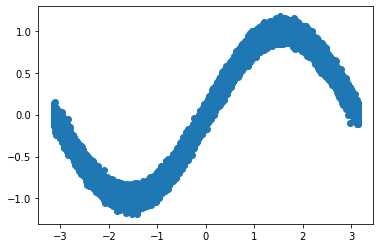

In [10]:
X = jnp.linspace(-3.14, 3.14, 100000).reshape(-1,1)
Y = jnp.sin(X)+0.05*random.normal(key, X.shape)
from matplotlib import pyplot as plt
plt.scatter(X,Y)
plt.show()

In [11]:
batch_size = 4096
num_batches = X.shape[0]//batch_size
epochs = 800
lr = 1e-2
print("no of datapoints {} \nbatch size {} \nno of batches : {}".format(
    X.shape[0],
    batch_size,
    num_batches
))

no of datapoints 100000 
batch size 4096 
no of batches : 24


In [12]:
jax.tree_map(lambda x:x.shape, mlp_params)

[[(128, 1), (128,)], [(256, 128), (256,)], [(1, 256), (1,)]]

In [13]:
import time

for epoch in range(epochs):
    loss = 0
    start = time.time()
    for batch in range(num_batches):
        if(batch==num_batches-1):
            batch_x = X[batch_size*batch:]
            batch_y = Y[batch_size*batch:]
        else:
            batch_x = X[batch_size*batch:batch_size*(batch+1)]
            batch_y = Y[batch_size*batch:batch_size*(batch+1)]

        mlp_params, L = update(mlp_params, batch_x, batch_y, lr)
        loss= loss + L*batch_size
    loss/=X.shape[0]
    end = time.time()
    if(epoch%50==0):   
        print("epoch : {} | loss : {} | time : {}".format(epoch, loss, end - start))

epoch : 0 | loss : 0.5037668943405151 | time : 1.9791288375854492
epoch : 50 | loss : 0.13025696575641632 | time : 0.093292236328125
epoch : 100 | loss : 0.1119573637843132 | time : 0.08575224876403809
epoch : 150 | loss : 0.09198926389217377 | time : 0.08437967300415039
epoch : 200 | loss : 0.05729426071047783 | time : 0.08399462699890137
epoch : 250 | loss : 0.02585020661354065 | time : 0.08655524253845215
epoch : 300 | loss : 0.01230527926236391 | time : 0.08966970443725586
epoch : 350 | loss : 0.007139465305954218 | time : 0.0863027572631836
epoch : 400 | loss : 0.004992601461708546 | time : 0.08643126487731934
epoch : 450 | loss : 0.003987732343375683 | time : 0.0856180191040039
epoch : 500 | loss : 0.003466135123744607 | time : 0.08499360084533691
epoch : 550 | loss : 0.003156614489853382 | time : 0.08628964424133301
epoch : 600 | loss : 0.0029592604842036963 | time : 0.08365750312805176
epoch : 650 | loss : 0.002831264166161418 | time : 0.08584809303283691
epoch : 700 | loss : 0

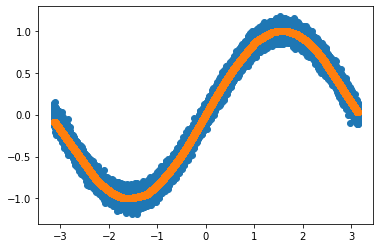

In [17]:
y_pred = batch_forward(mlp_params, X)

plt.scatter(X,Y)
plt.scatter(X, y_pred)
plt.show()